# Predecir el precio de acciones usando LSTM
### P.D.: Es un ejemplo, no se va a hacer millonario (Random Walk Theory)

Debido a las caracteristicas de las RNN, en particular LSTM (Long Short-Term Memory) es que que son utiles en la predcción donde exista dependencia de estados pasado. Es por ello que su utilización en series de tiempo resulta ideal.

El precio de una acción es una serie de tiempo, ya que el precio actual depende en cierta medida de el precio anterior.

Lo primero que haremos será obtener nuestros datos, para ello instalaremos yahoo_finance

In [34]:
# Importar librerias a usar
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd

# Preparación de los datos
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# modelo de ML
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# librería gráfica
import matplotlib.pyplot as plt

## Definición de parámetros
* **N_STEPS** el número de días de nuestra ventana de tiempo. Cuantos días tomaremos en cuenta para nuestra predicción

* **STOCK** la acción o activo que nos interesa que nos interesa , usaremos 'BTC-USD';

* **TEST_SIZE** tamaño porcentual del conjunto de test (0-1).

* **BATCH_SIZE** cuanto items entregaremos por batch

y miraremos los datos 5 años en el pasado, con intervalos de 1d (precio de cierre)

In [35]:
def calcular_dias_en_n_anios(n):
    cantidad_dias = n * 365  # Cantidad de días por año sin considerar años bisiestos
    cantidad_bisiestos = n // 4 - n // 100 + n // 400  # Cantidad de años bisiestos en n años
    cantidad_dias += cantidad_bisiestos  # Se suman los días adicionales por los años bisiestos
    return cantidad_dias

In [36]:
n = 5  # Cantidad de años
dias_totales = calcular_dias_en_n_anios(n)
print(f"La cantidad de días en {n} años, considerando años bisiestos, es: {dias_totales}")


La cantidad de días en 5 años, considerando años bisiestos, es: 1826


In [37]:
# Tamaño de la ventana, 7 (1 semana)
N_STEPS = 7

# Stock ticker, BTC-USD
STOCK = 'Bitcoin'
# fecha actual
# date_now = tm.strftime('%Y-%m-%d')
date_now = tm.strftime('%Y-%m-%d')

# 1829 días son años considerando años biciestos
date_n_years_back = (dt.date.today() - dt.timedelta(days = dias_totales)).strftime('%Y-%m-%d')

INTERVAL = '1d'

# size of test
TEST_SIZE = 0.3

# batch size
BATCH_SIZE = 32

### Obtener los datos

In [38]:
# Especifica la ruta y nombre del archivo CSV
csv_file = f'csv_files/coin_{STOCK}.csv'

# Define las fechas de inicio y fin
fecha_inicio = date_n_years_back
# fecha_fin = "2021-12-31"

# Lee el archivo CSV en un DataFrame
df = pd.read_csv(csv_file)

# Convierte la columna de fecha a tipo datetime
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

# Filtra el DataFrame según las fechas de inicio y fin
# df_filtrado = df[(df['Date'] >= fecha_inicio) & (df['Date'] <= fecha_fin)]
# Filtra el DataFrame según la fechas de inicio
df_filtrado = df[(df['Date'] >= fecha_inicio)]

# Imprime el DataFrame filtrado
df_filtrado


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
1868,1869,Bitcoin,BTC,2018-06-10,7499.549805,6709.069824,7499.549805,6786.020020,5.804840e+09,1.159483e+11
1869,1870,Bitcoin,BTC,2018-06-11,6910.180176,6706.629883,6799.290039,6906.919922,4.745270e+09,1.180259e+11
1870,1871,Bitcoin,BTC,2018-06-12,6907.959961,6542.080078,6905.819824,6582.359863,4.654380e+09,1.124919e+11
1871,1872,Bitcoin,BTC,2018-06-13,6631.660156,6285.629883,6596.879883,6349.899902,5.052350e+09,1.085306e+11
1872,1873,Bitcoin,BTC,2018-06-14,6707.140137,6334.459961,6342.750000,6675.350098,5.138710e+09,1.141060e+11
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [39]:
# # obtener los datos

# df = yf.get_data(STOCK, start_date = date_5_years_back,
#                  end_date=date_now,
#                  interval = INTERVAL)

# df.head(10)

La columna open contiene el precio de apertura del día y close el precio de cierre. Sólo utilizaremos el precio de cierre y la fecha. Convertiremos los precios a float32, para dado que ocuparemos en nuestra red 32 bit de precisión.

In [40]:
df_filtrado = df_filtrado.drop(['SNo','Name','Symbol','High','Low','Open','Volume','Marketcap'], axis=1)
df_filtrado['Close'] = df_filtrado['Close'].astype('float32')
print(f'new data frame shape: {df_filtrado.shape}')

new data frame shape: (1123, 2)


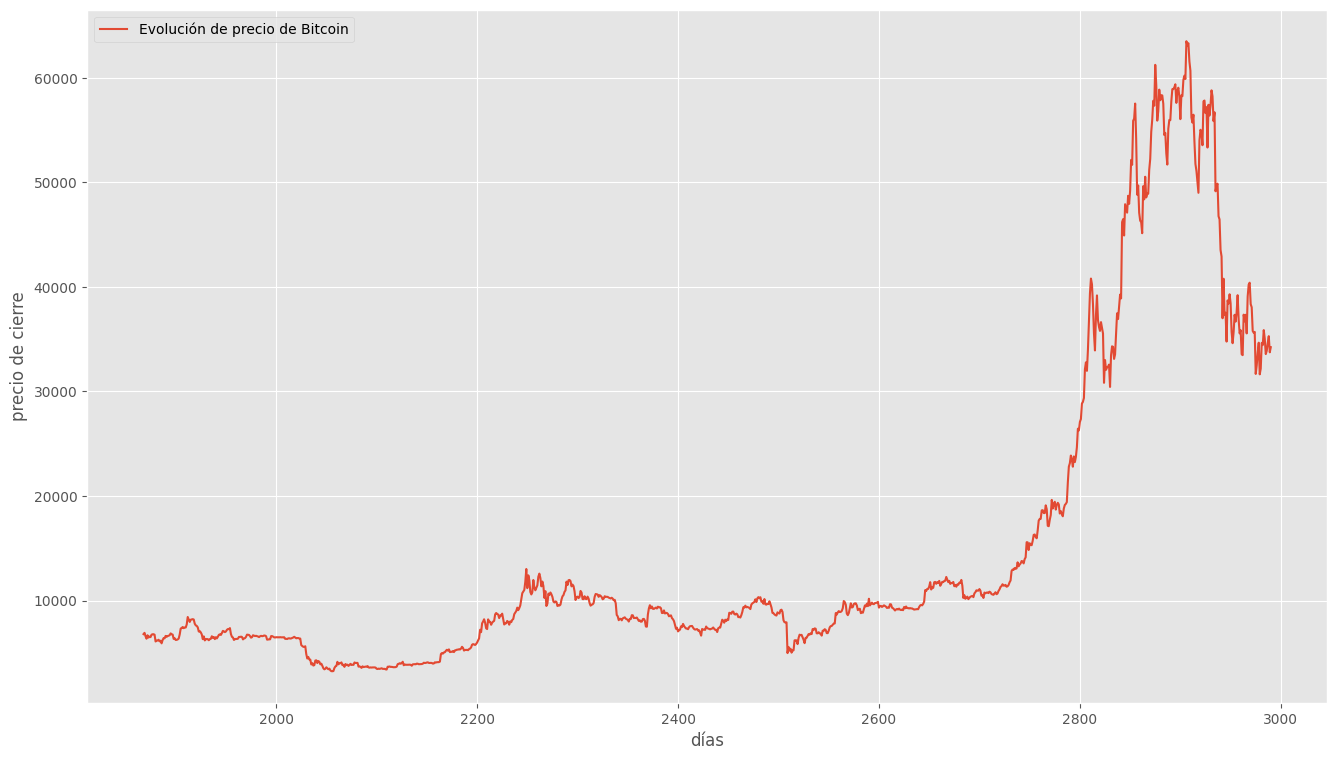

In [41]:
# Visualizemos los datos
plt.style.use(style='ggplot')
plt.figure(figsize=(16,9))
plt.plot(df_filtrado['Close'])
plt.xlabel('días')
plt.ylabel('precio de cierre')
plt.legend([f'Evolución de precio de {STOCK}'], loc='best')
plt.show()

In [42]:
df_filtrado.index = df_filtrado['Date']

df_filtrado = df_filtrado.drop(['Date'], axis=1)

df_filtrado.head(10)


,Close
Date,
2018-06-10,6786.020020
2018-06-11,6906.919922
2018-06-12,6582.359863
2018-06-13,6349.899902
2018-06-14,6675.350098
2018-06-15,6456.580078
2018-06-16,6550.160156
2018-06-17,6499.270020
2018-06-18,6734.819824


Vemos datos con gran variación en escala y sabemos que las redes funcionan mejor con datos escalados. En este caso aplicaremos MinMax al precio de cierre

## Separación en conjunto de entrenamiento y prueba

In [43]:
# Split into train and test sets
test_size = int(len(df_filtrado) * TEST_SIZE)
train_size = len(df_filtrado) - test_size

df_train = df_filtrado.iloc[:train_size, :]
df_test = df_filtrado.iloc[train_size:,:]

dataset_train, dataset_test = df_train.values, df_test.values

print(f'dataset_train length:{len(dataset_train)}, dataset_test length:{len(dataset_test)}')

dataset_train length:787, dataset_test length:336


In [44]:
# Split into train and test sets
dataset = df_filtrado.values

test_size = int(len(dataset) * TEST_SIZE)
train_size = len(dataset) - test_size

dataset_train, dataset_test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(f'dataset_train length:{len(dataset_train)}, dataset_test length:{len(dataset_test)}')

dataset_train length:787, dataset_test length:336


## Escalamiento de Datos

In [45]:
scaler = MinMaxScaler()
ds_scale_train = scaler.fit_transform(dataset_train)
ds_scale_test = scaler.transform(dataset_test)

## Crear características (X) y target (Y)
Dado que queremos predecir el precio de la acción en un determinado día usando como *features* los **N_STEPS** días previos, se perderán esos primeros días del conjunto de entrenamiento.

In [46]:
ds_scale_train.shape

(787, 1)

In [47]:
## con Drop last day dejamos le último día afuera objeto hacer la predicción final
##

def create_features_and_target(dataset, look_back = N_STEPS):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back -1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  
  return np.array(dataX), np.array(dataY)

In [48]:
trainX, trainY = create_features_and_target(ds_scale_train)
testX, testY = create_features_and_target(ds_scale_test)


# Para verificar consistencia
print(f'X train shape: {trainX.shape}, Y train shape: {trainY.shape}')
print(f'X test shape: {testX.shape}, Y test shape: {testY.shape}')



X train shape: (779, 7), Y train shape: (779,)
X test shape: (328, 7), Y test shape: (328,)


## Preparación de los datos.

Nuestro objetivo es poder predecir el precio de la acción para los próximos tres días. Esto significa que debemos preparar nuestros datos para tal efecto, haciendo un corrimiento en la serie de tiempo, objeto podamos con los datos del día de hoy, predecir el precio futuro.

In [49]:
class EarlyStoppingCustom(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stoppingcustom = EarlyStoppingCustom()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

## Optimizar las predicciones con optuna

In [50]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Definición de los hiperparámetros a optimizar
    num_units_lstm1 = trial.suggest_int('num_units_lstm1', 64, 512)
    num_units_lstm2 = trial.suggest_int('num_units_lstm2', 64, 512)
    num_units_lstm3 = trial.suggest_int('num_units_lstm3', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Creación del modelo LSTM
    model = Sequential(name='LSTM_Stack')
    model.add(LSTM(units=num_units_lstm1, return_sequences=True, input_shape=(N_STEPS, 1), name='LSTM_L1'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=num_units_lstm2, return_sequences=True, name='LSTM_L2'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=num_units_lstm3, name='LSTM_L3'))
    model.add(Dense(units=20, name='Dense_L4'))
    model.add(Dense(units=1, name='Dense_L5'))
    model.add(Activation('linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    # Entrenamiento del modelo con tus datos de entrenamiento
    model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), callbacks=[early_stopping])
    
    # Evaluación del modelo en el conjunto de validación
    y_pred = model.predict(testX)
    mse = mean_squared_error(testY, y_pred)
    
    # Retornar el MSE para optimizar
    return mse

In [51]:
# Optimización de hiperparámetros con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=8)

# Mejores hiperparámetros encontrados
best_params = study.best_params
print('Mejores hiperparámetros:', best_params)

# Mejor valor de la métrica objetivo
best_metric = study.best_value
print('Mejor valor de la métrica objetivo (MSE):', best_metric)

[I 2023-06-10 18:08:04,989] A new study created in memory with name: no-name-661f98f3-608f-48a6-b5ac-b0496a514cc7
C:\Users\roloa\AppData\Local\Temp\ipykernel_15500\2084379115.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


Epoch 1/10
25/25 [==============================] - 12s 212ms/step - loss: 2.1523 - mae: 0.6672 - val_loss: 9.2628 - val_mae: 2.4700
Epoch 2/10
25/25 [==============================] - 3s 134ms/step - loss: 0.0157 - mae: 0.0963 - val_loss: 8.6112 - val_mae: 2.3105
Epoch 3/10
25/25 [==============================] - 4s 143ms/step - loss: 0.0116 - mae: 0.0824 - val_loss: 8.9410 - val_mae: 2.3807
Epoch 4/10
25/25 [==============================] - 3s 138ms/step - loss: 0.0114 - mae: 0.0805 - val_loss: 9.0093 - val_mae: 2.3877
Epoch 5/10
25/25 [==============================] - 3s 134ms/step - loss: 0.0106 - mae: 0.0779 - val_loss: 8.9036 - val_mae: 2.3622
Epoch 6/10
19/25 [=====================>........] - ETA: 0s - loss: 0.0105 - mae: 0.0742

[W 2023-06-10 18:08:34,060] Trial 0 failed with parameters: {'num_units_lstm1': 365, 'num_units_lstm2': 483, 'num_units_lstm3': 213, 'dropout_rate': 0.2679289957527914, 'learning_rate': 0.01403224547704342} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\roloa\AppData\Local\Temp\ipykernel_15500\2084379115.py", line 30, in objective
    model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), callbacks=[early_stopping])
  File "c:\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\keras\engine\training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt: 

In [ ]:
best_params, best_metric

({'num_units_lstm1': 136,
  'num_units_lstm2': 242,
  'num_units_lstm3': 85,
  'dropout_rate': 0.340996920006685,
  'learning_rate': 5.271840410149952e-05},
 0.18672829866409302)

({'num_units_lstm1': 403,
  'num_units_lstm2': 499,
  'num_units_lstm3': 192,
  'dropout_rate': 0.3226826286678739,
  'learning_rate': 2.8689287823630512e-05},
 0.11623132228851318)

In [ ]:
# model = getCompileModel()

In [ ]:
# history = model.fit(trainX,trainY,
#             batch_size = BATCH_SIZE,
#             epochs = 80,
#             validation_split=0.05,
#             callbacks=[early_stopping])

In [52]:
def getCompileModel():
    # Entrenamiento de una nueva red neuronal con los mejores hiperparámetros
    best_model = Sequential(name='LSTM_Stack')
    best_model.add(LSTM(units=best_params['num_units_lstm1'], return_sequences=True, input_shape=(N_STEPS, 1), name='LSTM_L1'))
    best_model.add(Dropout(best_params['dropout_rate']))
    best_model.add(LSTM(units=best_params['num_units_lstm2'], return_sequences=True, name='LSTM_L2'))
    best_model.add(Dropout(best_params['dropout_rate']))
    best_model.add(LSTM(units=best_params['num_units_lstm3'], name='LSTM_L3'))
    best_model.add(Dense(units=20, name='Dense_L4'))
    best_model.add(Dense(units=1, name='Dense_L5'))
    best_model.add(Activation('linear'))

    optimizer = Adam(learning_rate=best_params['learning_rate'])
    best_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return best_model


In [53]:
best_params = {'num_units_lstm1': 403,
 'num_units_lstm2': 499,
 'num_units_lstm3': 192,
 'dropout_rate': 0.3226826286678739,
 'learning_rate': 2.8689287823630512e-05}

In [54]:
model = getCompileModel()

In [55]:
# Entrenamiento del modelo con los datos completos
history = model.fit(trainX, trainY,
            batch_size = BATCH_SIZE,
            epochs = 80,
            validation_split=0.05,
            callbacks=[early_stopping])

Epoch 1/80
24/24 [==============================] - 9s 152ms/step - loss: 0.1717 - mae: 0.3559 - val_loss: 0.2232 - val_mae: 0.4668
Epoch 2/80
24/24 [==============================] - 2s 92ms/step - loss: 0.0593 - mae: 0.1964 - val_loss: 0.0288 - val_mae: 0.1583
Epoch 3/80
24/24 [==============================] - 2s 96ms/step - loss: 0.0078 - mae: 0.0705 - val_loss: 0.0034 - val_mae: 0.0390
Epoch 4/80
24/24 [==============================] - 2s 94ms/step - loss: 0.0065 - mae: 0.0634 - val_loss: 0.0071 - val_mae: 0.0621
Epoch 5/80
24/24 [==============================] - 2s 97ms/step - loss: 0.0056 - mae: 0.0577 - val_loss: 0.0051 - val_mae: 0.0470
Epoch 6/80
24/24 [==============================] - 2s 98ms/step - loss: 0.0051 - mae: 0.0551 - val_loss: 0.0051 - val_mae: 0.0468
Epoch 7/80
24/24 [==============================] - 2s 99ms/step - loss: 0.0046 - mae: 0.0525 - val_loss: 0.0054 - val_mae: 0.0501
Epoch 8/80
24/24 [==============================] - 2s 98ms/step - loss: 0.0046 - 

In [56]:
model.save('LSTM_stock.h5')

## Rendimiento del modelo en conjunto de prueba

In [57]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

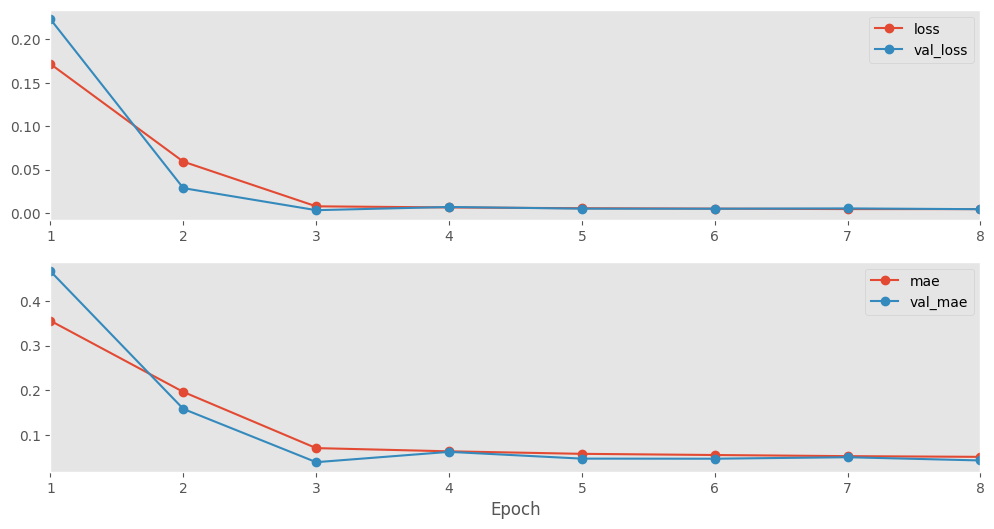

In [58]:
plot_history(history)

## Rendimiento del modelo en conjunto de prueba

In [59]:
def compute_metrics(true_series, forecast):
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

  return mse, mae

In [60]:
forecast = model.predict(testX)
mse, mae = compute_metrics(testY, forecast.squeeze())

print(f'Model MSE: {mse}, MAE: {mae}') #MSE: Mean Squared Error, MAE: Mean Absolute Error.

11/11 [==============================] - 1s 28ms/step
Model MSE: 0.13316920399665833, MAE: 0.2672256827354431


## Predicción precio mañana

In [61]:
next_day_features = np.expand_dims(np.array(ds_scale_test[-N_STEPS:,0]), axis=0)
pred = model.predict(next_day_features)

forecast_price = scaler.inverse_transform(pred)[0][0]

print(f'El precio de {STOCK} para el día de de mañana es {forecast_price}')

1/1 [==============================] - 0s 20ms/step
El precio de Bitcoin para el día de de mañana es 34125.5078125


([<matplotlib.axis.XTick at 0x18b7dd665d0>,
 [Text(0.0, 0, '2020-08-13'),
  Text(41.0, 0, '2020-09-23'),
  Text(82.0, 0, '2020-11-03'),
  Text(123.0, 0, '2020-12-14'),
  Text(164.0, 0, '2021-01-24'),
  Text(205.0, 0, '2021-03-06'),
  Text(246.0, 0, '2021-04-16'),
  Text(287.0, 0, '2021-05-27')])

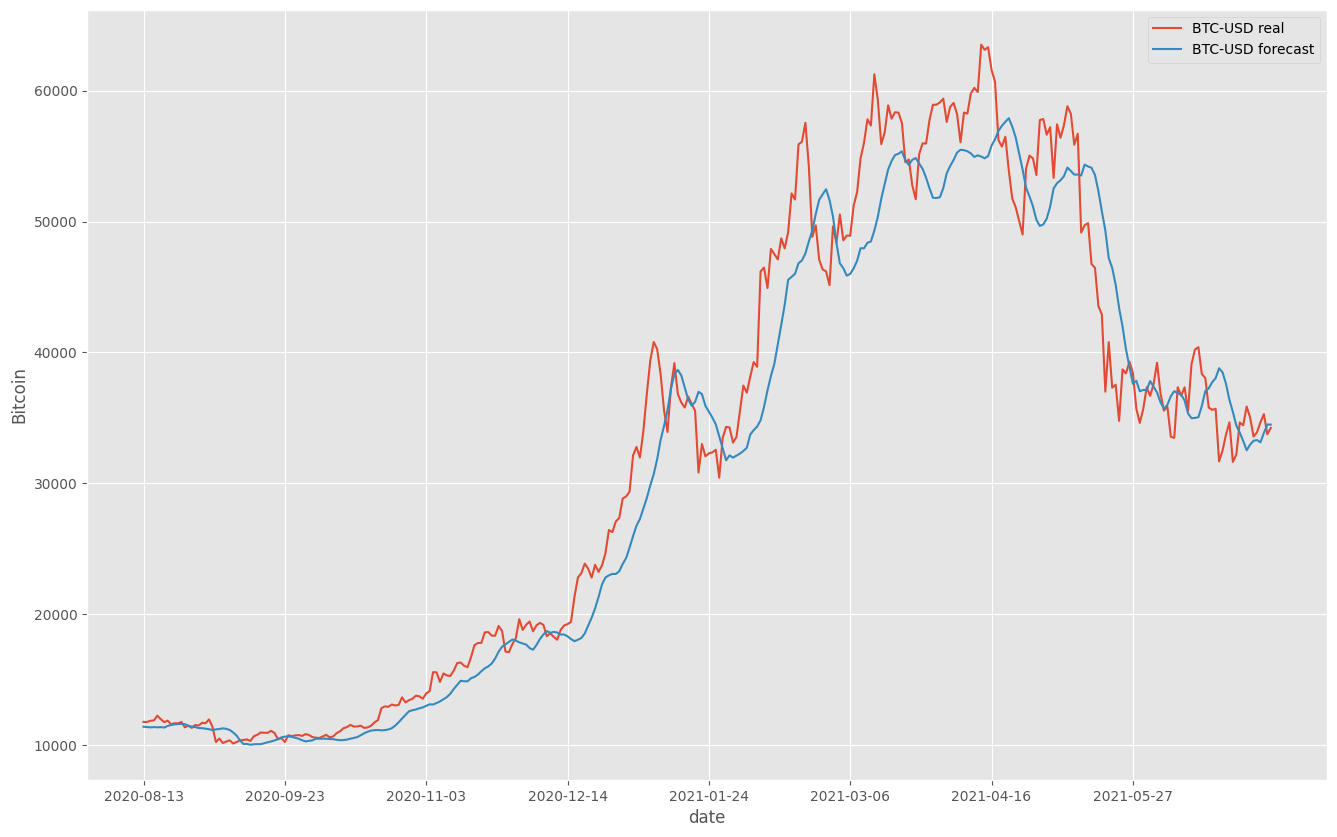

In [62]:
forecast_prices = scaler.inverse_transform(forecast).squeeze()
plt.figure(figsize=(16,10))
dates = df_test.index[N_STEPS+1:,]

plt.plot(dates,dataset_test[N_STEPS+1:,], label='BTC-USD real')
plt.plot(dates,scaler.inverse_transform(forecast), label='BTC-USD forecast')
plt.xlabel('date')
plt.ylabel(f'{STOCK}')
plt.legend()
# Establecer intervalos de visualización en el eje x
num_ticks = 8  # Número deseado de ticks en el eje x
step = len(dates) // num_ticks  # Calcular el paso entre los ticks
plt.xticks(dates[::step])  # Establecer los ticks en intervalos equidistantes

# Guardar los datos predichos

In [64]:
df_output = pd.DataFrame({ 'Date': dates, 'Forecast': forecast_prices})
df_output.head()

,Date,Forecast
0,2020-08-13,11408.461914
1,2020-08-14,11392.274414
2,2020-08-15,11364.495117
3,2020-08-16,11383.862305
4,2020-08-17,11368.515625


In [72]:
import requests
import json
url = "https://1sxs2ownii.execute-api.us-east-1.amazonaws.com/qa/upload"
headers = {
    'Content-Type': 'application/json'
}

data = []
payload = {
        "data": data
    }
for index in df_output.index:
    row = df_output.iloc[index]
    fecha = row['Date']
    precio = row['Forecast']
    
    data.append({
            "id": str(index),
            "forecast": str(precio),
            "day": str(fecha),
            "currency": str(STOCK)
        })
    
response = requests.post(url, data=json.dumps(payload), headers=headers)

In [ ]:
# pd.DataFrame.to_csv(df_output, f'{STOCK}.csv')

In [ ]:
def get_stock_data(df_output):
    data = df_output['Forecast']
    return data

In [ ]:
def get_stock_list():
    # Define aquí tu lista de acciones seleccionables
    stock_list = ['AAPL', 'GOOGL', 'MSFT']
    return stock_list

In [ ]:
import streamlit as st
# Configuración de la página de Streamlit
st.title("Entrenamiento de Redes Neuronales LSTM para Acciones")
stock_list = get_stock_list()
selected_stock = st.selectbox("Selecciona una acción", stock_list)

# Obtén los datos de la acción seleccionada
data = get_stock_data(df_output)

# Entrenar el modelo y obtener las predicciones

# Visualización de los gráficos
st.subheader("Gráficos")
st.line_chart(dates)
st.line_chart(forecast_prices)

KeyboardInterrupt: 